In [89]:
import sys
sys.path.append('/home/daniel/PycharmProjects/WageringSystem')

from Experiments.FundHistorySummary import FundHistorySummary
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from numpy import cumsum

def show_summary_grid(fund_history_summary: FundHistorySummary) -> None:
    sns.set(rc={'figure.figsize':(26,15)})
    f, axes = plt.subplots(2, 1)

    start_wealth = 100
    bet_limit_fraction = 0.33
    show_fixed_betting_wealth_progression(axes[0], fund_history_summary, start_wealth=start_wealth, betting_limit=100)
    show_dynamic_betting_wealth_progression(axes[1], fund_history_summary, start_wealth=start_wealth, bet_limit_fraction=bet_limit_fraction)

def show_fixed_betting_wealth_progression(axis, fund_history_summary: FundHistorySummary, start_wealth: float, betting_limit: float):
    snapshots = fund_history_summary.snapshots
    dates = [snapshot.date.split()[0] for snapshot in snapshots]
    absolute_payouts = [snapshot.payout_percentages * betting_limit for snapshot in snapshots]
    wealth_progression = [start_wealth + payout_sum for payout_sum in cumsum(absolute_payouts)]

    sns.lineplot(x=dates, y=wealth_progression, ax=axis)

    max_date = datetime.strptime(max(dates), '%Y-%m-%d')
    min_date = datetime.strptime(min(dates), '%Y-%m-%d')
    summary_day_interval = (max_date - min_date).days
    axis.xaxis.set_major_locator(mdates.DayLocator(interval=int(summary_day_interval / 5)))

    axis.set_title(f"Wealth progression over unseen test races. Betting limit is: {betting_limit}")
    axis.set_xlabel(f"Date")
    axis.set_ylabel(f"Current Wealth")

def show_dynamic_betting_wealth_progression(axis, fund_history_summary: FundHistorySummary, start_wealth: float, bet_limit_fraction: float) -> None:
    dates = [snapshot.date.split()[0] for snapshot in fund_history_summary.snapshots]

    current_wealth = start_wealth
    wealth_progression = []
    for i in range(len(fund_history_summary.snapshots)):
        betting_limit = current_wealth * bet_limit_fraction
        current_wealth += fund_history_summary.snapshots[i].payout_percentages * betting_limit
        wealth_progression.append(current_wealth)

    sns.lineplot(x=dates, y=wealth_progression, ax=axis)

    max_date = datetime.strptime(max(dates), '%Y-%m-%d')
    min_date = datetime.strptime(min(dates), '%Y-%m-%d')
    summary_day_interval = (max_date - min_date).days
    axis.xaxis.set_major_locator(mdates.DayLocator(interval=int(summary_day_interval / 5)))

    axis.set_title(f"Wealth progression over unseen test races. Betting limit is current wealth multiplied by {bet_limit_fraction:.2f}")
    axis.set_xlabel(f"Date")
    axis.set_ylabel(f"Current Wealth")

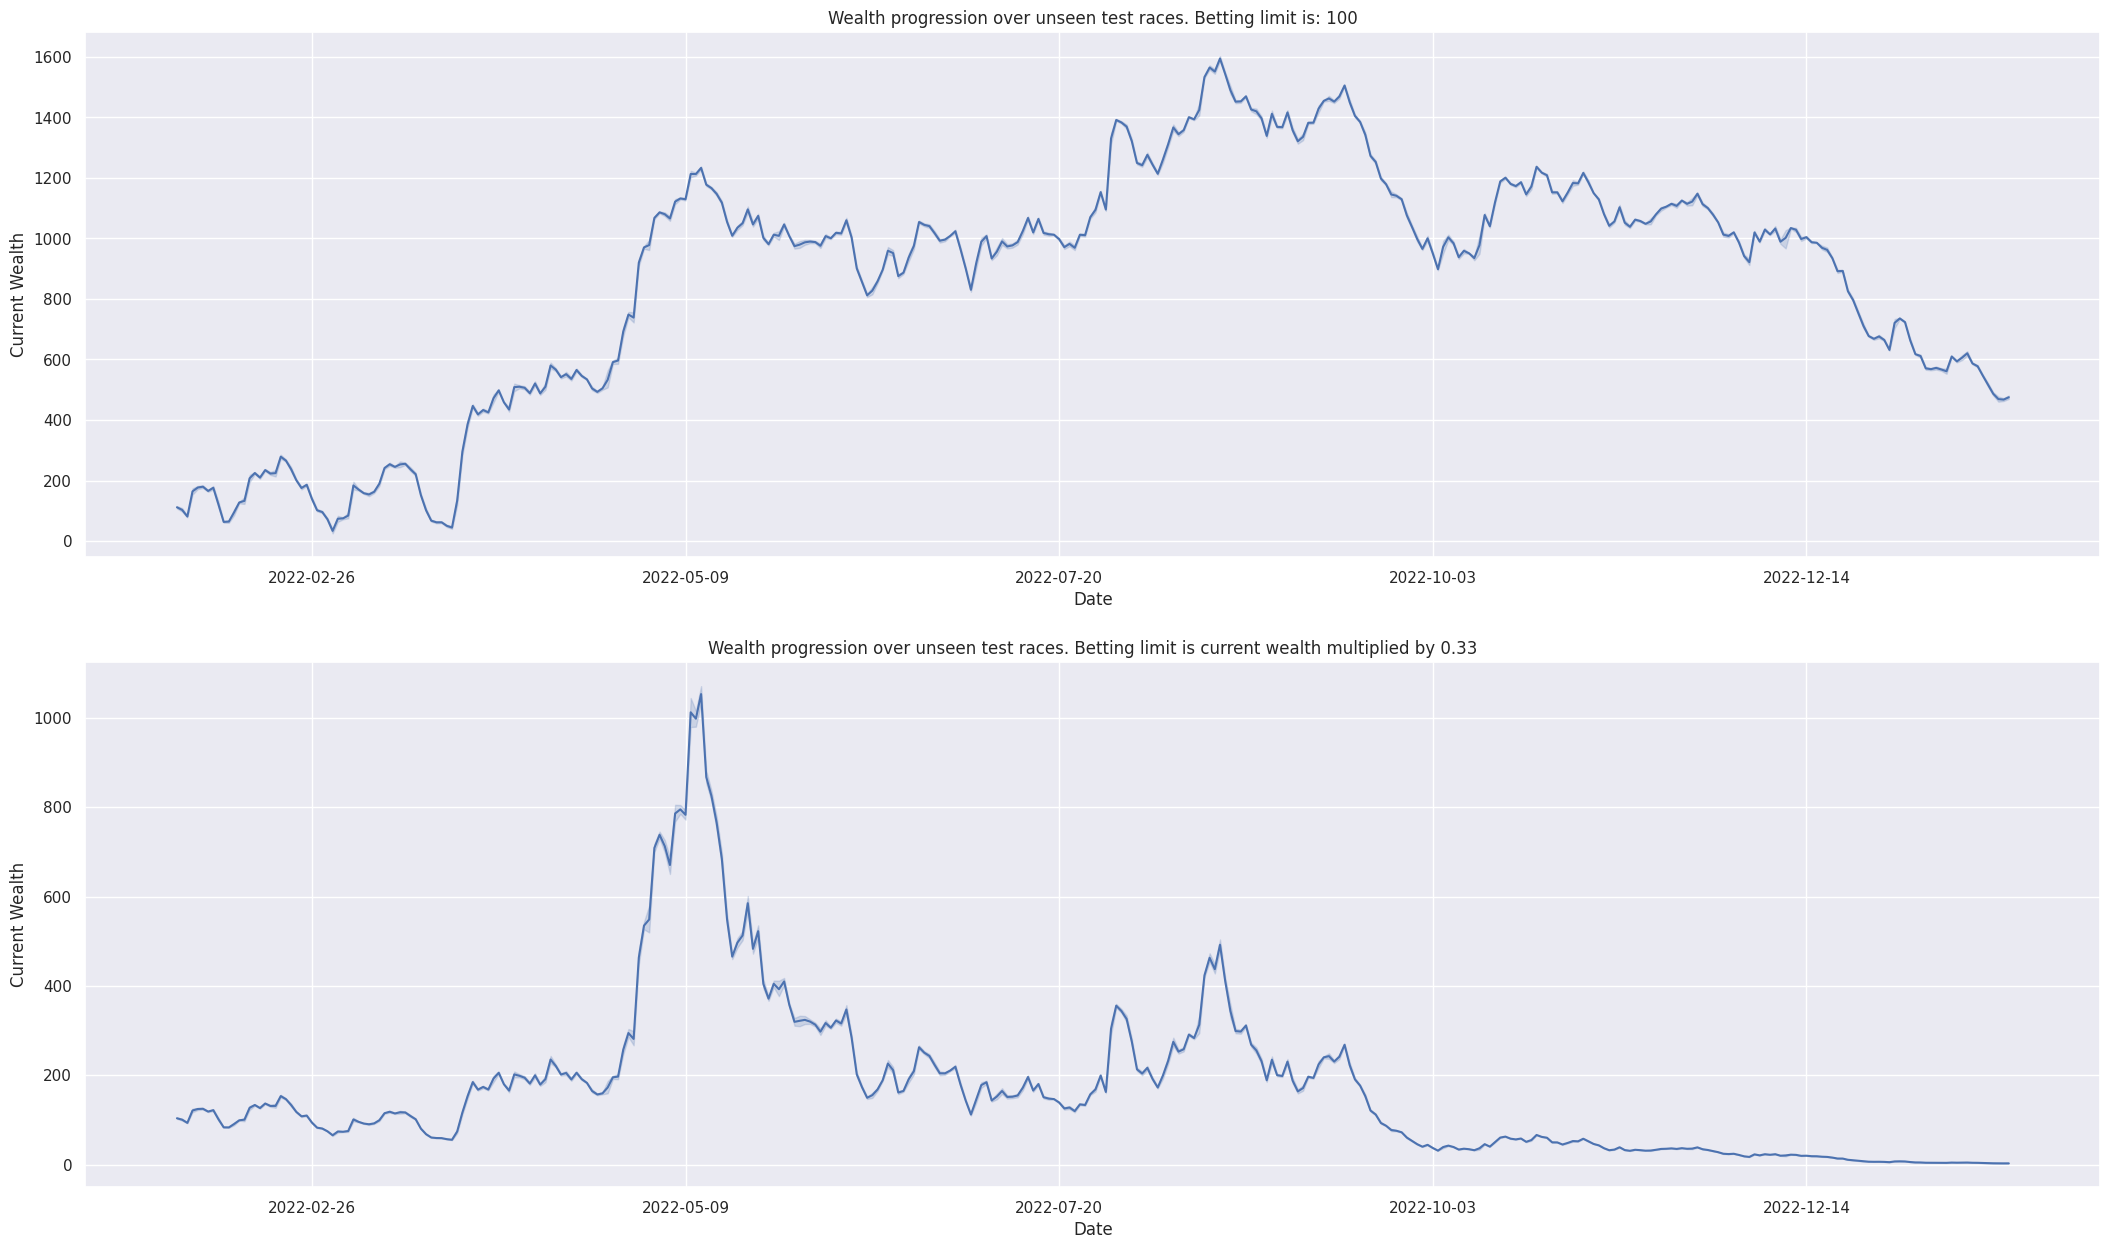

In [90]:
import pickle

FUND_HISTORY_SUMMARIES_PATH = "../data/fund_history_summaries.dat"

with open(FUND_HISTORY_SUMMARIES_PATH, "rb") as f:
    fund_history_summary = pickle.load(f)

show_summary_grid(fund_history_summary)

bet rate: 0.9957
max losses: 0.4187914194761382
min:-0.36110004050912914
max:1.8463253315462609
avg:0.0004134239385075441
Average winning odds: 9.355859649122808
{1: 0.00041520933866379643, 0: 0.0}


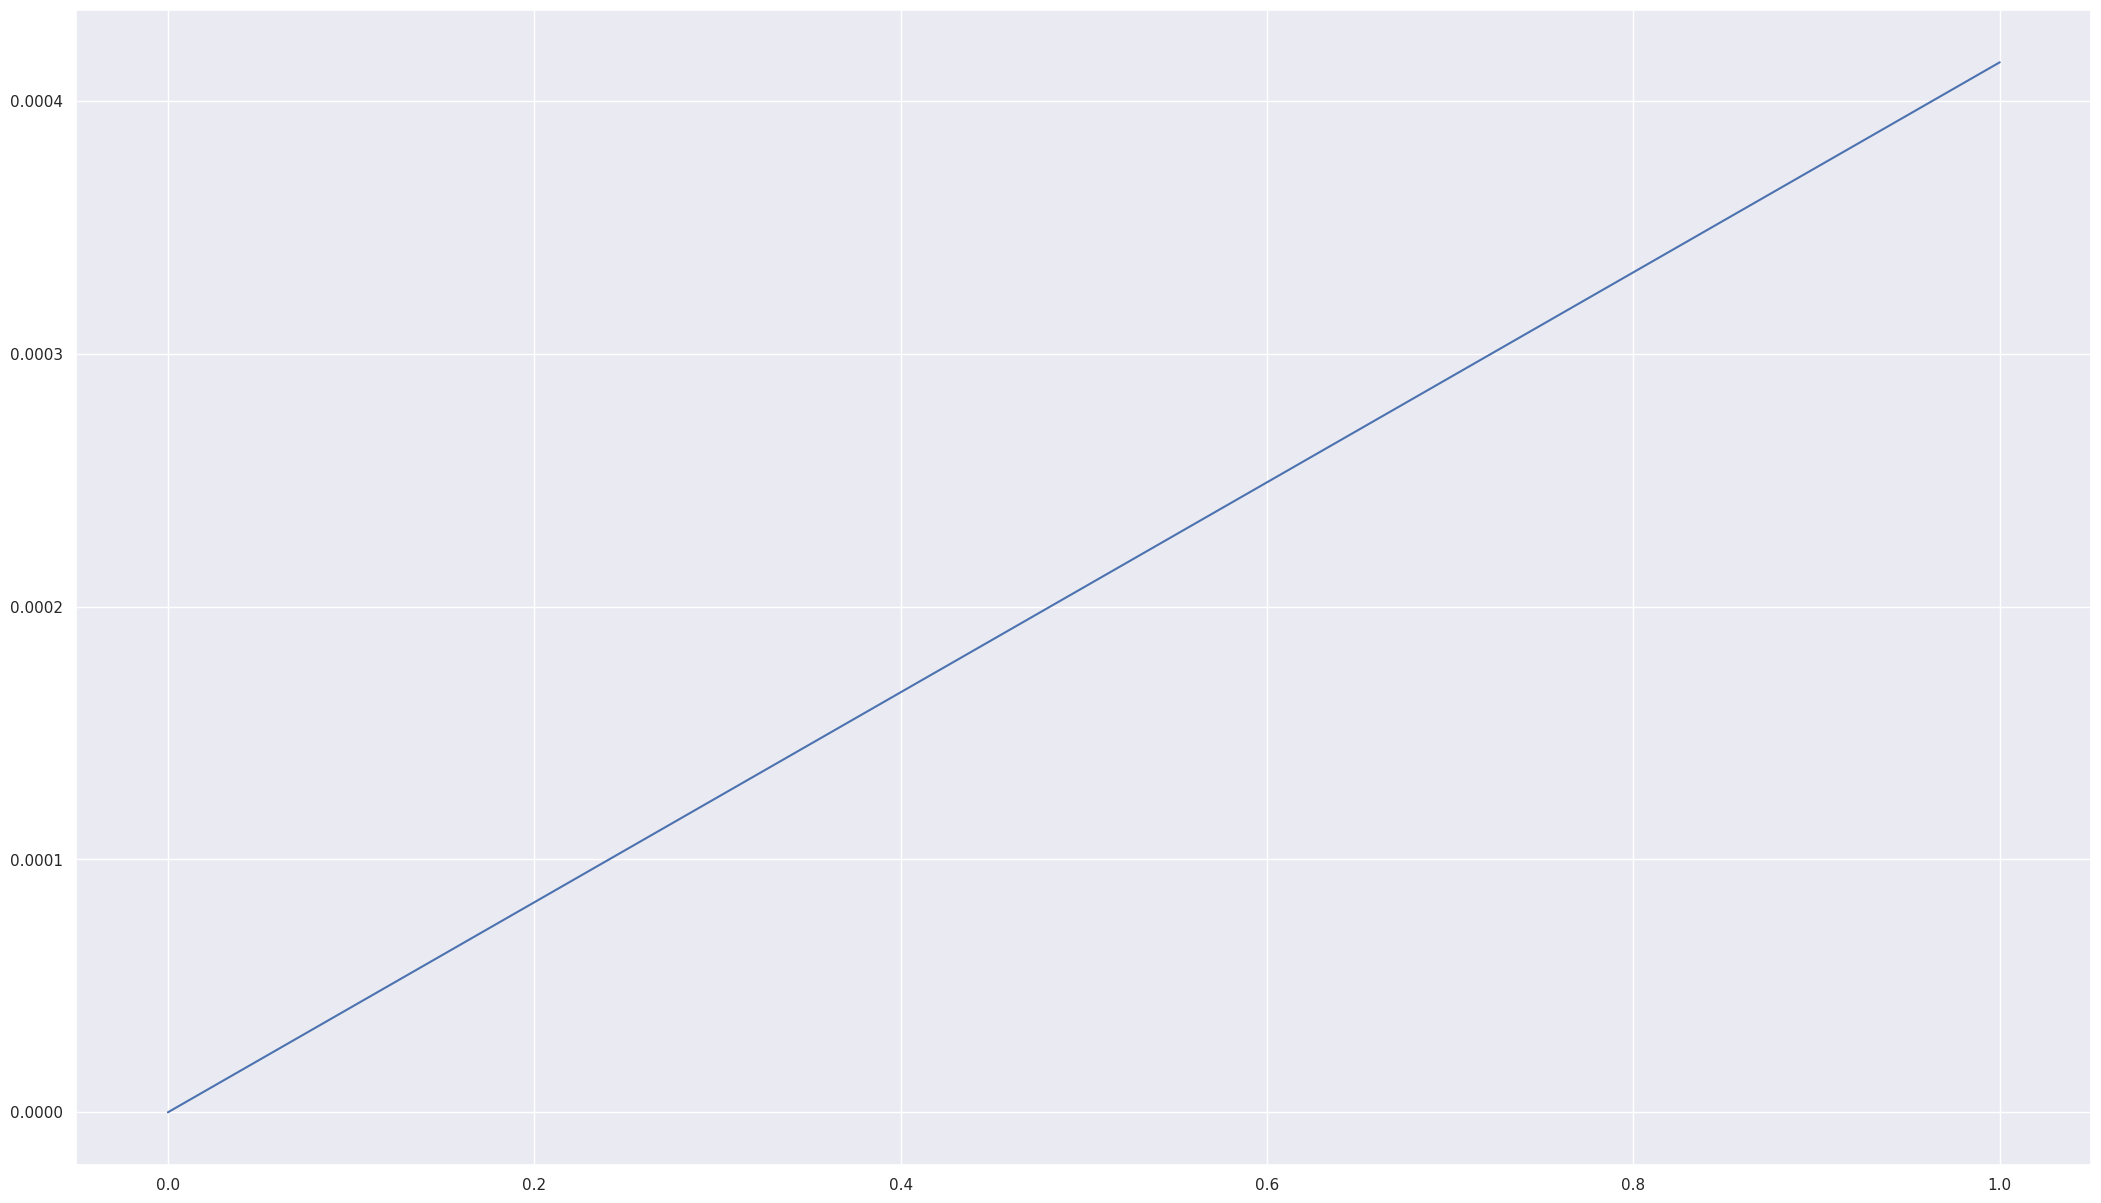

In [91]:
from numpy import average, mean

losses = [betting_slip.loss for betting_slip in fund_history_summary.betting_slips.values()]
payouts = [betting_slip.payout_percentage for betting_slip in fund_history_summary.betting_slips.values()]

print(f"bet rate: {fund_history_summary.bet_rate}")
print(f"max losses: {max(losses)}")
print(f"min:{min(payouts)}")
print(f"max:{max(payouts)}")
print(f"avg:{average(payouts)}")

odds = []
payout_bet_count_dist = {}
for betting_slip in fund_history_summary.betting_slips.values():
    odds += [bet.odds for bet in betting_slip.bets if bet.win > 0]
    n_bets = len(betting_slip.bets)
    if n_bets not in payout_bet_count_dist:
        payout_bet_count_dist[n_bets] = {"total": betting_slip.payout_percentage, "n": 1}
    else:
        payout_bet_count_dist[n_bets]["total"] += betting_slip.payout_percentage
        payout_bet_count_dist[n_bets]["n"] += 1

for key in payout_bet_count_dist:
    if "total" in payout_bet_count_dist[key]:
        payout_bet_count_dist[key] = payout_bet_count_dist[key]["total"] / payout_bet_count_dist[key]["n"]

print(f"Average winning odds: {average(odds)}")
print(payout_bet_count_dist)
num_bets = [len(betting_slip.bets) for betting_slip in fund_history_summary.betting_slips.values()]
ax = sns.lineplot(data=payout_bet_count_dist)

In [93]:
sorted_betting_slips = sorted(fund_history_summary.betting_slips.values(), key=lambda x: x.payout_percentage, reverse=True)

for betting_slip in sorted_betting_slips:
    if betting_slip.race_id == 5216654:
        print(betting_slip)

worst_betting_slips = sorted_betting_slips[-20:]

for betting_slip in worst_betting_slips:
    print(f"https://www.racebets.de/de/pferdewetten/race/details/id/{betting_slip.race_id}/")

Betting slip:
(Fractional) total loss: 0.36110004050912914
Bets:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Win bet:
---------------------------------------
Horse number: 1
Odds of horse: 4.3
(Fractional) stakes: 0.36110004050912914
Potential win: 1.5139119198345237
Estimated success probability: 0.5227501809612705
---------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

https://www.racebets.de/de/pferdewetten/race/details/id/5328721/
https://www.racebets.de/de/pferdewetten/race/details/id/5429844/
https://www.racebets.de/de/pferdewetten/race/details/id/5064006/
https://www.racebets.de/de/pferdewetten/race/details/id/5318632/
https://www.racebets.de/de/pferdewetten/race/details/id/4782718/
https://www.racebets.de/de/pferdewetten/race/details/id/5407075/
https://www.racebets.de/de/pferdewetten/race/details/id/5504903/
https://www.racebets.de/de/pferdewetten/race/details/id/5016710/
https://www.racebets.de/de/pferdewetten/race/details/id/5072293/
http

## Real payout plotting

12.333333333333343


Text(0, 0.5, 'Wealth change in %')

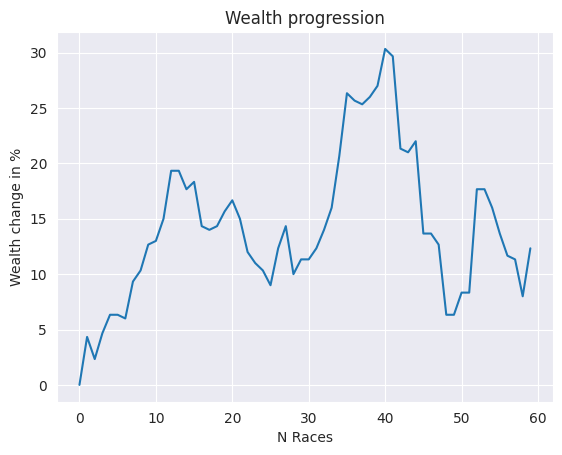

In [24]:
from numpy import cumsum
import seaborn as sns
real_payouts = [
    0, 13, -6, 7, 5, 0, -1, 10, 3, 7, 1, 6, 13, 0, -5, 2, -12,
    -1, 1,
    4, 3, -5, -9, -3, -2, -4, 10, 6, -13, 4, 0, 3,
    5, 6, 14, 17, -2, -1, 2, 3, 10, -2,
    -25, -1, 3, -25, 0, -3, -19, 0, 6, 0, 28, 0, -5, -7, -6, -1, -10, 13,
]

real_payouts = [real_payout / 3 for real_payout in real_payouts]

print(cumsum(real_payouts)[-1])

ax = sns.lineplot(cumsum(real_payouts))
ax.set_title("Wealth progression")
ax.set_xlabel("N Races")
ax.set_ylabel("Wealth change in %")

In [10]:
import pandas as pd

# Create a sample dataframe with three columns 'A', 'B', and 'C'
df = pd.DataFrame({'A': [1, 1, 1, 2, 2, 2, 2, 2],
                   'B': [2, 3, 5, 10, 20, 55, 65, 75],
                   'C': [2, 2, 2, 3, 3, 3, 3, 3]})

# Group the dataframe by column 'A' and get the values of 'B' and 'C' for each group
grouped = df.groupby('A')[['B', 'C']].agg({'B': lambda x: list(x), 'C': 'first'})

# Convert the grouped values to a list of tuples
result = [tuple(row) for row in grouped.values]

print(result)

[([2, 3, 5], 2), ([10, 20, 55, 65, 75], 3)]
